<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/UAS/Chapter%2017/Autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Linear Autoencoder vs PCA

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


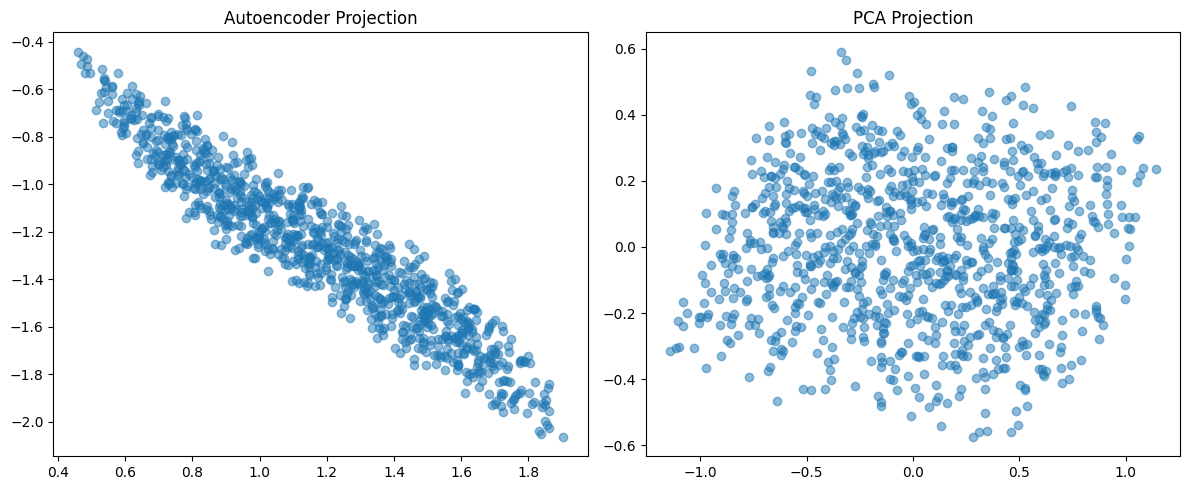

In [3]:
# Generate 3D data dan proyeksikan ke 2D
np.random.seed(42)
X_3D = np.random.rand(1000, 3) @ np.array([[0.5, 0.1], [0.4, 0.3], [0.2, 0.9]]) + 0.1
X_3D = X_3D @ np.random.randn(2, 3)  # ubah ke bentuk akhir (1000, 3)

# Encoder
input_layer = keras.Input(shape=(3,))
encoded = layers.Dense(2)(input_layer)

# Decoder
decoded = layers.Dense(3)(encoded)

# Autoencoder
autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_3D, X_3D, epochs=20, verbose=0)

# Ambil encoder saja
encoder = keras.Model(inputs=input_layer, outputs=encoded)
X_proj = encoder.predict(X_3D)

# PCA sebagai pembanding
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X_3D)

# Visualisasi
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_proj[:,0], X_proj[:,1], alpha=0.5)
plt.title("Autoencoder Projection")

plt.subplot(1,2,2)
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA Projection")
plt.tight_layout()
plt.show()


Variational Autoencoder (VAE)

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(log_var / 2) * eps

latent_dim = 2
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z])

decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(28*28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(decoder_inputs, decoder_outputs)

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

vae = VAE(encoder, decoder)
(X_train, _), _ = keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_train = np.expand_dims(X_train, -1)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_train, epochs=3, batch_size=128)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.4252
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2651
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2635


 GAN - Basic Generator & Discriminator

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 selesai
Epoch 2 selesai
Epoch 3 selesai
Epoch 4 selesai
Epoch 5 selesai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


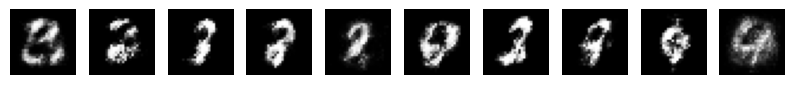

In [6]:
# Generator
generator = keras.models.Sequential([
    layers.Dense(128, activation="relu", input_shape=[100]),
    layers.Dense(28*28, activation="sigmoid"),
    layers.Reshape([28, 28])
])

# Discriminator
discriminator = keras.models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
discriminator.compile(loss="binary_crossentropy", optimizer="adam")

# GAN
discriminator.trainable = False
gan_input = keras.Input(shape=[100])
gan_output = discriminator(generator(gan_input))
gan = keras.Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer="adam")

# Training loop
(X_train, _), _ = keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0

batch_size = 32
for epoch in range(5):
    for _ in range(X_train.shape[0] // batch_size):
        noise = np.random.normal(size=[batch_size, 100])
        gen_images = generator.predict(noise, verbose=0)

        real_imgs = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
        X_combined = np.concatenate([real_imgs, gen_images])
        y_combined = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        discriminator.trainable = True
        discriminator.train_on_batch(X_combined, y_combined)

        noise = np.random.normal(size=[batch_size, 100])
        y_gan = np.ones((batch_size, 1))
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gan)

    print(f"Epoch {epoch+1} selesai")

# Visualisasi
samples = generator.predict(np.random.normal(size=[10, 100]))
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(samples[i], cmap="gray")
    plt.axis("off")
plt.show()


### 🔍 Visualisasi Gambar Hasil Generator

Pada tahap ini, kita melakukan **evaluasi kualitatif terhadap performa Generator** dari model GAN dengan cara menghasilkan beberapa contoh gambar digit sintetis.

Fungsi `generate_and_plot_images(generator, epoch, test_input)` digunakan untuk:

- Menghasilkan gambar digit dengan **input noise acak** (disebut *latent vector*) yang diberikan ke generator.
- Melakukan *forward pass* tanpa training (`training=False`).
- Menampilkan hasil dalam bentuk grid 1 baris × 10 kolom.

Output visual yang ditampilkan merupakan hasil dari generator yang mencoba mereplikasi distribusi gambar digit MNIST.

> ✅ **Semakin realistis dan jelas angka yang terbentuk, semakin baik performa generator.**
>  
> 🚧 Jika gambar masih terlihat blur atau tidak menyerupai angka, berarti model memerlukan pelatihan lebih lanjut (peningkatan jumlah epoch atau tuning hyperparameter).



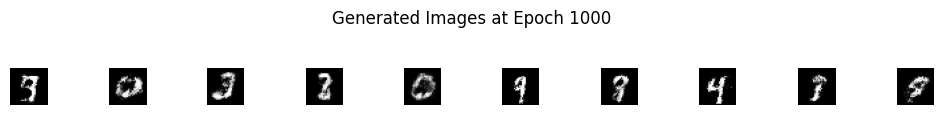

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Fungsi visualisasi hasil dari generator
def generate_and_plot_images(generator, epoch, test_input):
    predictions = generator(test_input, training=False)
    fig = plt.figure(figsize=(10, 1))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 10, i + 1)
        # Tidak perlu ambil channel ke-0 karena output generator berdimensi (28, 28)
        plt.imshow(predictions[i] * 255.0, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Generated Images at Epoch {epoch}', y=1.1)
    plt.tight_layout()
    plt.show()

# Generate 10 gambar baru menggunakan generator
random_latent_vectors = tf.random.normal([10, 100])
generate_and_plot_images(generator, epoch=1000, test_input=random_latent_vectors)